# File Size

In [1]:
import pandas as pd
import os
data_path = "../Data/nyctaxi"
os.chdir(data_path)

In [2]:
fldr = "tests"
os.makedirs(fldr, exist_ok=True)

In [3]:
df = pd.read_csv("part_csv_stage1/year=2016/part_000.csv")

In [4]:
df.to_csv(f"{fldr}/file.csv", index=False)
df.to_parquet(f"{fldr}/file.parquet", index=False)

In [8]:
!ls -l --block-size=M {fldr}

total 75M
-rw-rw-r-- 1 baobob baobob 62M Dec 31 18:16 file.csv
-rw-rw-r-- 1 baobob baobob 13M Dec 31 18:16 file.parquet


In [10]:
62/13

4.769230769230769

In [18]:
for ext in ["zip", "gzip", "bz2", "xz"]:
    df.to_csv(f"{fldr}/file.csv.{ext}",
              index=False,
              compression=ext)

## Comparing file size

In [1]:
import os
import pandas as pd
data_path = "../Data/nyctaxi"
os.chdir(data_path)
fldr = 'tests'

In [2]:
fns = os.listdir(fldr)
fns = [os.path.join(fldr, fn) for fn in fns]

In [3]:
fns

['tests/file.parquet',
 'tests/file.csv.gzip',
 'tests/file.csv.xz',
 'tests/file.csv',
 'tests/file.csv.zip',
 'tests/file.csv.bz2']

In [4]:
df_comp = pd.DataFrame({"fn": fns})

In [5]:
df_comp["size"] = df_comp["fn"].map(os.path.getsize)

In [6]:
df_comp

,fn,size
0,tests/file.parquet,13337679
1,tests/file.csv.gzip,18233926
2,tests/file.csv.xz,10086316
3,tests/file.csv,64761409
4,tests/file.csv.zip,18568424
5,tests/file.csv.bz2,10808373


In [7]:
df_comp["ext"] = df_comp["fn"].str.split(".").str[-1]

In [8]:
df_comp["sizeMB"] = df_comp["size"]/1e6

In [9]:
df_comp = df_comp.sort_values("size",
                              ascending=False)\
                 .reset_index(drop=True)

In [10]:
df_comp

,fn,size,ext,sizeMB
0,tests/file.csv,64761409,csv,64.761409
1,tests/file.csv.zip,18568424,zip,18.568424
2,tests/file.csv.gzip,18233926,gzip,18.233926
3,tests/file.parquet,13337679,parquet,13.337679
4,tests/file.csv.bz2,10808373,bz2,10.808373
5,tests/file.csv.xz,10086316,xz,10.086316


In [11]:
df_comp["comp_ratio"] = df_comp["size"].max()/df_comp["size"]

In [12]:
df_comp

,fn,size,ext,sizeMB,comp_ratio
0,tests/file.csv,64761409,csv,64.761409,1.000000
1,tests/file.csv.zip,18568424,zip,18.568424,3.487717
2,tests/file.csv.gzip,18233926,gzip,18.233926,3.551699
3,tests/file.parquet,13337679,parquet,13.337679,4.855523
4,tests/file.csv.bz2,10808373,bz2,10.808373,5.991781
5,tests/file.csv.xz,10086316,xz,10.086316,6.420720


In [47]:
%%timeit
df = pd.read_parquet("tests/file.parquet")

443 ms ± 9.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
df = pd.read_csv("tests/file.csv")

1.29 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
timing_csv = %timeit -o pd.read_parquet("tests/file.parquet")

459 ms ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
timing_csv.average

0.45860674614284236

In [63]:
%%timeit
o = pd.read_csv("tests/file.csv.xz")

2.27 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
fn = fns[0]

In [31]:
timing = %timeit -o -r 10 pd.read_parquet(fn)

457 ms ± 18.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [32]:
timing.average

0.45652748360025724

In [142]:
def timeit_read(fn):
    ext = fn.split(".")[-1]
    if ext == 'csv':
        ext = None
    if ext == 'parquet':
        timing = %timeit -o -r 10 pd.read_parquet(fn)
    else:
        timing = %timeit -o -r 10 pd.read_csv(fn, compression=ext)
    return timing.average

In [143]:
df_comp["reading_time"] = df_comp["fn"].map(timeit_read)

1.45 s ± 138 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
1.9 s ± 125 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
1.81 s ± 48.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
477 ms ± 43.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
7.27 s ± 277 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
2.56 s ± 137 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [145]:
df_comp

,fn,size,ext,sizeMB,comp_ratio,reading_time
0,tests/file.csv,64761409,csv,64.761409,1.000000,1.447287
1,tests/file.csv.zip,18568424,zip,18.568424,3.487717,1.896430
2,tests/file.csv.gzip,18233926,gzip,18.233926,3.551699,1.809178
3,tests/file.parquet,13337679,parquet,13.337679,4.855523,0.476689
4,tests/file.csv.bz2,10808373,bz2,10.808373,5.991781,7.266610
5,tests/file.csv.xz,10086316,xz,10.086316,6.420720,2.560274


# Plots

In [149]:
import plotly.express as px
import plotly.graph_objects as go

large_rockwell_template = dict(
    layout=go.Layout(title_font=dict(family="Rockwell", size=24))
)

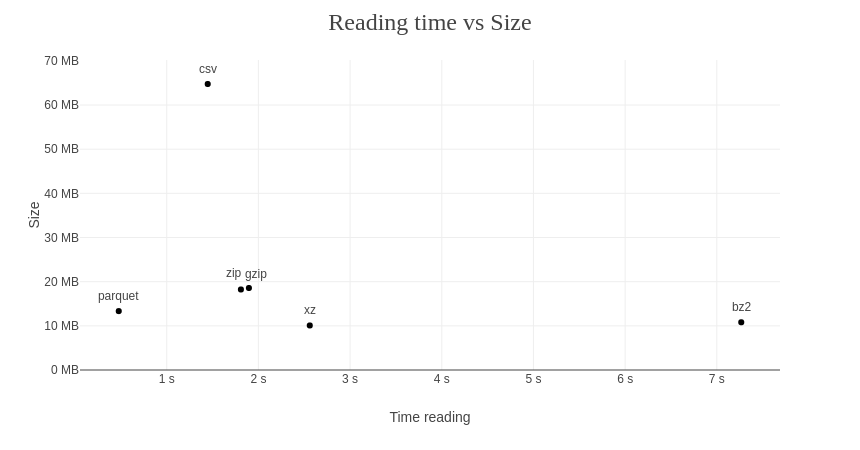

In [151]:
fig = px.scatter(df_comp,
                 x="reading_time",
                 y="sizeMB",
                 labels={"sizeMB":"Size",
                        "reading_time": "Time reading"})
fig.update_traces(marker={"color":"black"})\
   .update_layout(title="Reading time vs Size",
                  title_x=0.5,
                  xaxis_ticksuffix = ' s',
                  yaxis_ticksuffix = ' MB',
                  template=large_rockwell_template)\
   .update_yaxes(rangemode="tozero")
for i, row in df_comp.iterrows():
    if row["ext"] == "zip":
        xshift = -15
    elif row["ext"] == 'gzip':
        xshift = 15
    else:
        xshift = 0
    fig.add_annotation(x=row["reading_time"], 
            y=row["sizeMB"],
            text=row["ext"],
            yshift=15,
            xshift=xshift,
            showarrow=False)
fig.show()

In [124]:
df_comp

,fn,size,ext,sizeMB,comp_ratio,reading_time
0,tests/file.csv,64761409,csv,64.761409,1.000000,1.374582
1,tests/file.csv.zip,18568424,zip,18.568424,3.487717,1.722839
2,tests/file.csv.gzip,18233926,gzip,18.233926,3.551699,1.862778
3,tests/file.parquet,13337679,parquet,13.337679,4.855523,0.485804
4,tests/file.csv.bz2,10808373,bz2,10.808373,5.991781,7.187436
5,tests/file.csv.xz,10086316,xz,10.086316,6.420720,2.367066


In [154]:
df = df_comp.copy()

In [157]:
df["read_speed"] = df["reading_time"]/df["reading_time"].min()

In [171]:
df["read_speed"].astype(int).astype("str") + "x"

0     3x
1     3x
2     3x
3     1x
4    15x
5     5x
Name: read_speed, dtype: object

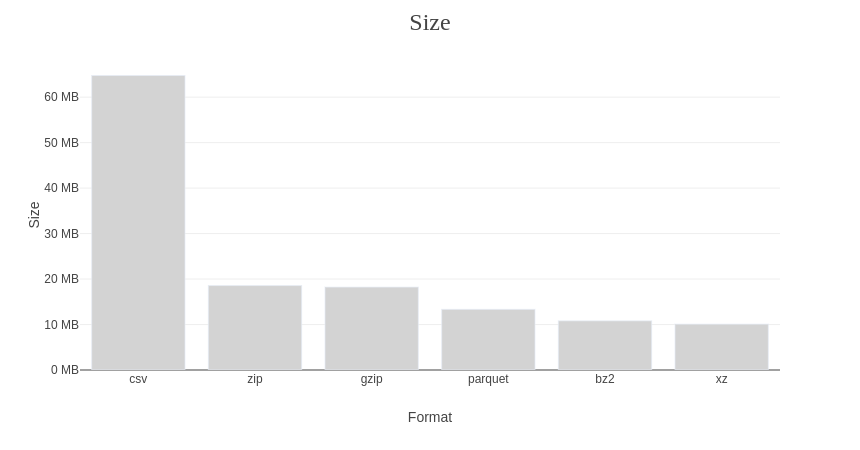

In [152]:
fig = px.bar(df_comp, x="ext",y="sizeMB",
       labels={"sizeMB":"Size",
               "reading_time": "Time reading",
               "ext": "Format"})

fig.update_traces(marker={"color":"lightgrey"})\
   .update_layout(title="Size",
                  title_x=0.5,
                  yaxis_ticksuffix = ' MB',
                  template=large_rockwell_template)
fig.show()

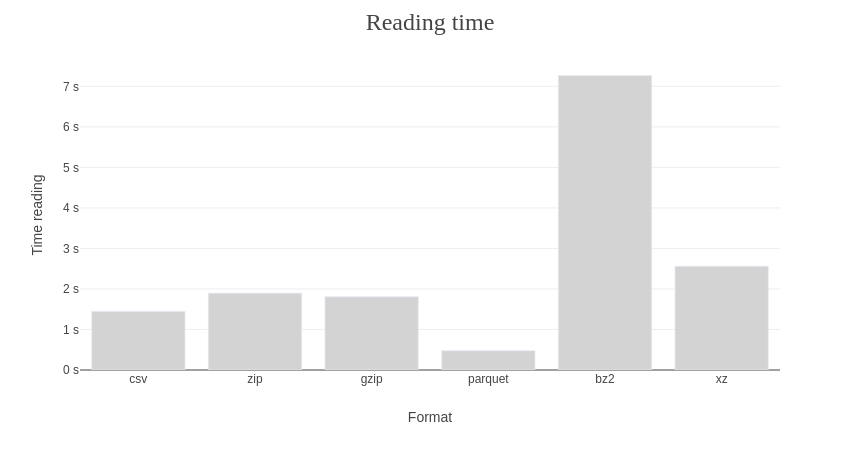

In [153]:
fig = px.bar(df_comp, x="ext",y="reading_time",
       labels={"sizeMB":"Size",
               "reading_time": "Time reading",
               "ext": "Format"})

fig.update_traces(marker={"color":"lightgrey"})\
   .update_layout(title="Reading time",
                  title_x=0.5,yaxis_ticksuffix = ' s',
                  template=large_rockwell_template)
fig.show()

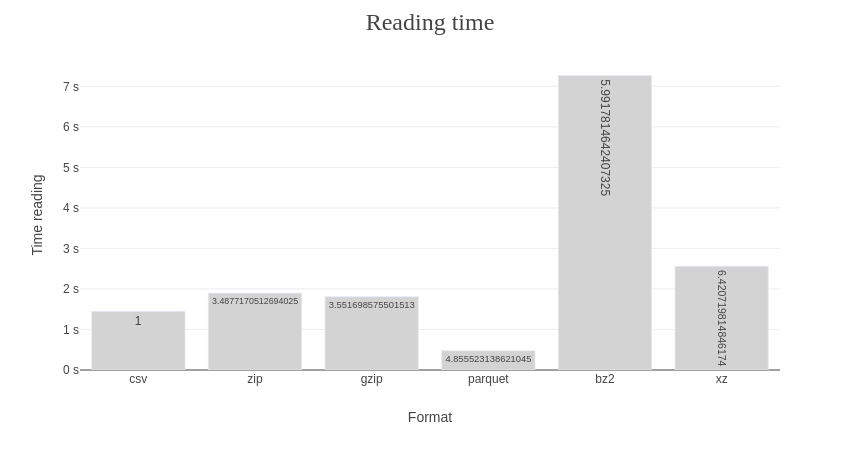

In [161]:
fig = px.bar(df_comp, x="ext",y="reading_time",
       labels={"sizeMB":"Size",
               "reading_time": "Time reading",
               "ext": "Format"})

fig.update_traces(marker={"color":"lightgrey"})\
   .update_layout(title="Reading time",
                  title_x=0.5,yaxis_ticksuffix = ' s',
                  template=large_rockwell_template)
fig.show()

# Performances 

In [2]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import os
data_path = "../Data/nyctaxi"
os.chdir(data_path)

cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:40505 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


## test1

In [5]:
%%time
ddf = dd.read_csv("part_csv_stage1/year=2016/*")
grp = ddf.groupby("VendorID")["passenger_count"]\
         .sum().compute()
grp

CPU times: user 35.7 s, sys: 3.39 s, total: 39.1 s
Wall time: 4min 14s


VendorID
1     77280114
2    140069243
3         5945
Name: passenger_count, dtype: int64


CPU times: user 35.7 s, sys: 3.39 s, total: 39.1 s
Wall time: 4min 14s

In [6]:
client.restart()

Client Scheduler: tcp://127.0.0.1:36741 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.50 GB


## Test2

In [3]:
ddf = dd.read_csv("part_csv_stage1/year=2016/*")
ddf = ddf[["VendorID", "passenger_count"]]
grp = ddf.groupby("VendorID")["passenger_count"].sum()

In [5]:
%%time
grp.compute()

CPU times: user 32.9 s, sys: 3.84 s, total: 36.7 s
Wall time: 4min 20s


VendorID
1     77280114
2    140069243
3         5945
Name: passenger_count, dtype: int64

CPU times: user 32.9 s, sys: 3.84 s, total: 36.7 s
Wall time: 4min 20s

## Test parquet1

In [3]:
ddf = dd.read_parquet("part_parquet_stage1/year=2016/")
grp = ddf.groupby("VendorID")["passenger_count"]\
         .sum().compute()

In [4]:
%%time
grp.compute()

CPU times: user 14.3 s, sys: 1.53 s, total: 15.9 s
Wall time: 1min 43s


VendorID
1     77280114
2    140069243
3         5945
Name: passenger_count, dtype: int64

CPU times: user 14.3 s, sys: 1.53 s, total: 15.9 s
Wall time: 1min 43s

## Test parquet 2

In [3]:
ddf = dd.read_parquet("part_parquet_stage1/year=2016/",
                      columns=["VendorID", "passenger_count"])
grp = ddf.groupby("VendorID")["passenger_count"]\
         .sum().compute()

In [5]:
%%time
grp.compute()

CPU times: user 2.97 s, sys: 301 ms, total: 3.28 s
Wall time: 10.2 s


VendorID
1     77280114
2    140069243
3         5945
Name: passenger_count, dtype: int64

CPU times: user 2.97 s, sys: 301 ms, total: 3.28 s
Wall time: 10.2 s

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

large_rockwell_template = dict(
    layout=go.Layout(title_font=dict(family="Rockwell", size=24))
)

In [6]:
df = pd.DataFrame({"Format":["csv", "csv (2 cols)",
                             "parquet", "parquet (2 cols)"],
                  "Timing": [254, 260, 103, 10.2]})

In [7]:
df

,Format,Timing
0,csv,254.0
1,csv (2 cols),260.0
2,parquet,103.0
3,parquet (2 cols),10.2


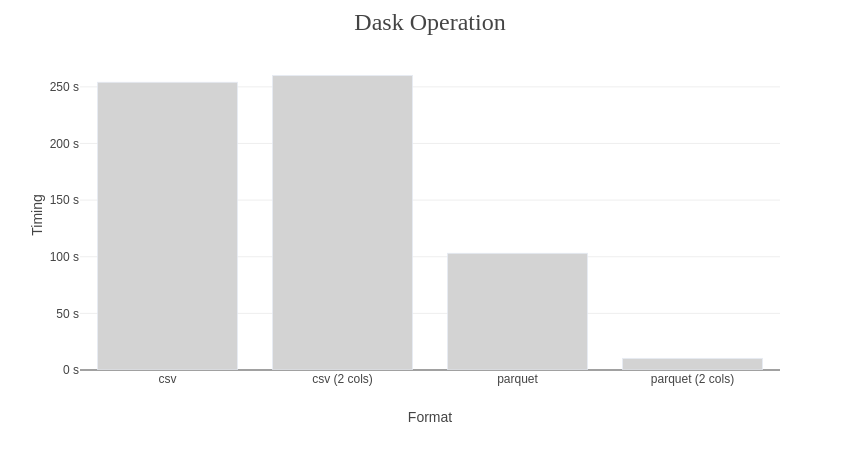

In [10]:
fig = px.bar(df, x="Format",y="Timing")

fig.update_traces(marker={"color":"lightgrey"})\
   .update_layout(title="Dask Operation",
                  title_x=0.5,yaxis_ticksuffix = ' s',
                  template=large_rockwell_template)
fig.show()

In [12]:
254/103

2.466019417475728

In [13]:
254/10.2

24.901960784313726

In [15]:
df["Speedup"] =  254/df["Timing"]

In [21]:
df["text"] = df["Speedup"].round(1).astype("str") + "x"

In [27]:
df["text"] = df["text"].map(lambda x: f"<b>{x}</b>")

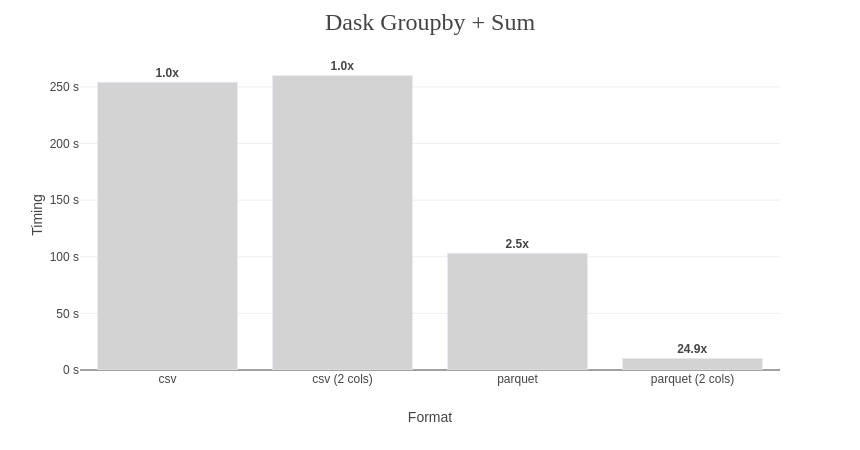

In [28]:
fig = px.bar(df, x="Format",y="Timing", text="text")

fig.update_traces(marker={"color":"lightgrey"}, textposition="outside")\
   .update_layout(title="Dask Groupby + Sum",
                  title_x=0.5,yaxis_ticksuffix = ' s',
                  template=large_rockwell_template)
fig.show()